# Eilidh Pike - Bank Customer Churn Prediction 

Task: You are working as Data Scientist in one of the leading banking sector firms. The firm is losing customers at an alarming rate. Your task is to analyse the dataset provided(Exploratory data analysis) and build a machine learning model to predict which customers are likely to churn, so that the company can take proactive measures to retain them.

Aims:
* Identify and visualise which factors will contribute to customer churn
* Build a machine learning model that will predict whether the bank's customers will churn or not.

#### Dataset Information

* ID — Corresponds to the row number.
* CustomerId — Bank customer Identification Number.
* Surname – Surnames of customers. 
* CreditScore - Credit Score of customer.
* Geography - Customer location.
* Gender - Gender of the customer. 
* Age - Age of the customer. 
* Tenure - How long the customer has been a member of the bank. 
* Balance - The balance of a customer.
* NumOfProducts (Number of products) - How many products (accounts and cards) a customer has with the bank. 
* HasCrCard (Has credit card) - If the customer has a credit card with the bank. 
* IsActiveMember - If the customer is a member of the bank.
* EstimatedSalary - The estimated salary of the customer with the bank. 
* Exited - If the customer has left the bank. 

In [1]:
#Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Seaborn Parameters 
sns.set_palette("PRGn")
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
# Read the train dataset
df = pd.read_csv('C:\\Users\\eilid\\Desktop\\BiP Solutions Churn Task\\Dataset\\train.csv', delimiter=',')

# 1) Exploratory Data Analysis (EDA)

In [3]:
# Displaying the first 5 rows of the df
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.shape

(165034, 14)

* Train dataset has 165034 observations and 14 rows

In [5]:
# Check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


* No missing values in the dataframe.

In [6]:
# Get unique count for each variable
df.nunique()

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

In [7]:
#Checking for duplicate rows
duplicate_rows = df[df.duplicated()]
duplicate_rows.shape[0]

0

In [8]:
df['Surname'].value_counts()

Hsia         2456
T'ien        2282
Hs?          1611
Kao          1577
Maclean      1577
             ... 
Samaniego       1
Lawley          1
Bonwick         1
Tennant         1
Elkins          1
Name: Surname, Length: 2797, dtype: int64

Columns 'id' and 'CustomerID' are merely labels for the observations and have no relevance to customer churn. 'Surname' has been removed as there as multiple instances of the same surname and will lead to either model overfitting or potential bias towards a certain surname.  

In [9]:
# Dropping columns not relevant to predicting customer churn
df = df.drop(["id", "CustomerId", "Surname"], axis = 1)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,165034.0,656.454373,80.103340,350.00,597.00,659.0,710.0000,850.00
Age,165034.0,38.125888,8.867205,18.00,32.00,37.0,42.0000,92.00
Tenure,165034.0,5.020353,2.806159,0.00,3.00,5.0,7.0000,10.00
Balance,165034.0,55478.086689,62817.663278,0.00,0.00,0.0,119939.5175,250898.09
NumOfProducts,165034.0,1.554455,0.547154,1.00,1.00,2.0,2.0000,4.00
HasCrCard,165034.0,0.753954,0.430707,0.00,1.00,1.0,1.0000,1.00
IsActiveMember,165034.0,0.497770,0.499997,0.00,0.00,0.0,1.0000,1.00
EstimatedSalary,165034.0,112574.822734,50292.865585,11.58,74637.57,117948.0,155152.4675,199992.48
Exited,165034.0,0.211599,0.408443,0.00,0.00,0.0,0.0000,1.00


Credit Score: The distribution of credit scores appears to be somewhat right-skewed, as the mean is slightly lower than the median, and the maximum value is much higher than the 75th percentile. This skewness suggests that there may be a larger proportion of customers with relatively higher credit scores compared to those with lower credit scores.

Age: The average age of customers in the dataset is around 38 years old, with a standard deviation of approximately 8.87 years. The majority of customers fall within the age range of 32 to 42 years, as the 25th to 75th percentiles (Q1 to Q3) indicate. The youngest customer is 18 years old, while the oldest is 92 years old. This could highlight some potential outliers in the age column. The bank may not be as appealing to older customers- things like the loss of in-person banks and a lack of benefits, or handling of pensions may influence this. 

Tenure: On average, customers have been with the bank for around 5 years, with a standard deviation of approximately 2.81 years. The minimum tenure is 0 years, which indicates that the bank is still attracting new customers. The maximum is 10 years - it's not clear if the longest a customer has stayed is 10 years or if this is the data cut-off. 

Balance: The average balance across all customers is approximately 55,478, with a large standard deviation of around 62,817. There are customers with a balance of 0 - it might be worth exploring the correlation between balance and active member status. The highest balance observed is 250,898.

Number of Products (NumOfProducts): On average, customers have approximately 1.55 products with the bank, with a standard deviation of around 0.55. The majority of customers have either 1 or 2 products, but some have up to 4 products.

Has Credit Card (HasCrCard): Around 75% of customers in the dataset have a credit card, as indicated by the mean value. This suggests that credit card ownership is quite common among the bank's customers.

Is Active Member (IsActiveMember): Roughly half of the customers are active members, based on the mean value. This indicates that the other half may be inactive or less engaged with the bank's services. We could expect to see a relationship between active members, balance, and number of products.

Estimated Salary: The average estimated salary of customers is approximately 112,575, with a standard deviation of around $50,293. The minimum estimated salary is 11.58, while the maximum is 199,992.

### Correlation between variables

C:\Users\eilid\AppData\Local\Temp\ipykernel_13236\349184144.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr().round(2)


<Axes: >

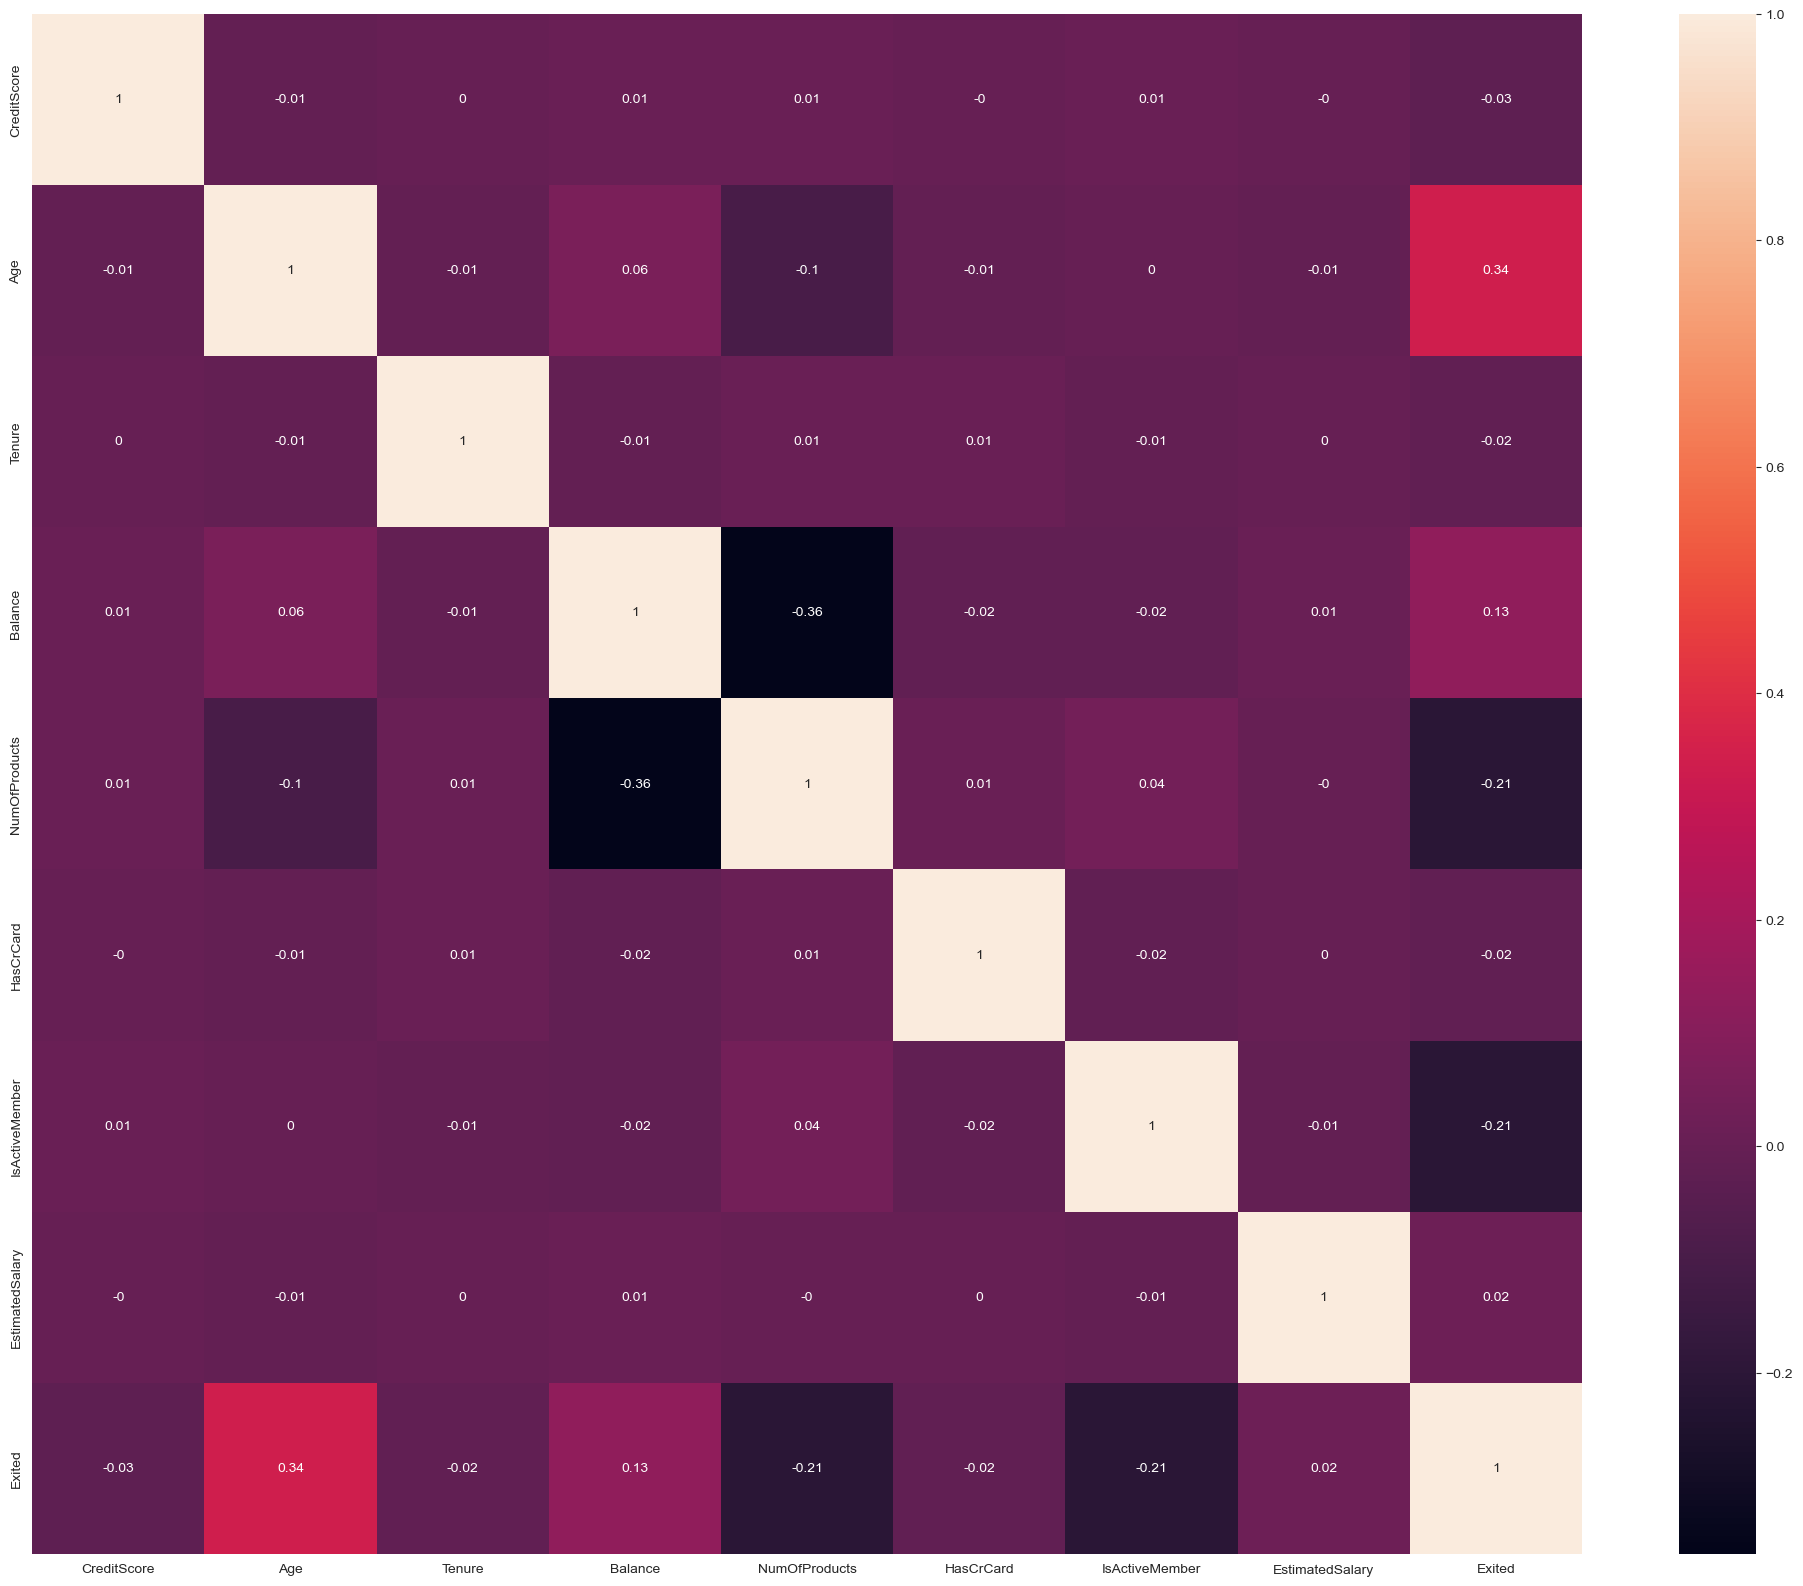

In [11]:
corr = df.corr().round(2)
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True)

From a first look, none of our variables display multicollinearity. There are a few relationships of note to the dependent variable:
* Age and Exited have a slightly positive correlation
* Balance and Exited have a slightly positive correlation
* NumofProducts and Exited have a slightly negative correlation
* IsActiveMember and Exited have a slightly negative correlation

From a first look, we expect these variables to have an influence whether a customer churns. 

### Target Variable: Exited

The target variable has been previously encoded. The values are:
* 0 = Customer has not churned
* 1 = Customer has churned 

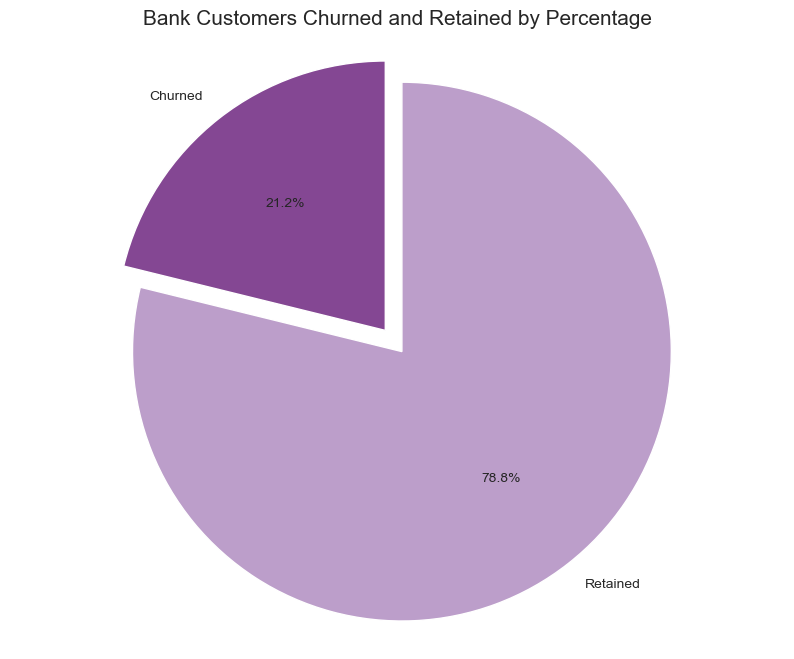

In [12]:
labels = 'Churned', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
plt.title("Bank Customers Churned and Retained by Percentage", size = 15)
plt.show()

* The bank retains 78.8% of its customers and churns 21.2%.
* The target variable is imbalanced with our main concern, churned being very undersampled. In this classification task, this might lead to the models being biased towards predicting the majority class (Retained), and may perform poorly identifying churned customers. Therefore, a class oversampling technique (SMOTE) will be used in the data preprocessing stage.

### Continuous Variables: Age, Credit Score, Balance & Estimated Salary 

In [13]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']

In [14]:
#Printing the value counts for the continuous columns
for column in continuous:
    print("Value counts for", column, ":")
    print(df[column].value_counts())
    print()

Value counts for Age :
37.00    9255
38.00    9246
35.00    9118
34.00    8625
36.00    8556
         ... 
84.00       4
83.00       3
85.00       3
36.44       1
32.34       1
Name: Age, Length: 71, dtype: int64

Value counts for CreditScore :
850    2532
678    2299
684    1718
667    1658
705    1605
       ... 
419       1
386       1
358       1
423       1
373       1
Name: CreditScore, Length: 457, dtype: int64

Value counts for Balance :
0.00         89648
124577.33       88
127864.40       64
122314.50       63
129855.32       59
             ...  
125824.21        1
158741.56        1
126815.52        1
61172.57         1
110993.29        1
Name: Balance, Length: 30075, dtype: int64

Value counts for EstimatedSalary :
88890.05     178
140941.47    107
167984.72    100
90876.95      98
129964.94     98
            ... 
102747.73      1
170593.45      1
109179.48      1
60538.47       1
71173.03       1
Name: EstimatedSalary, Length: 55298, dtype: int64



* Age: The most common age among customers is 37 years old, with the least common ages being 83, 84, and 85 years. This could indicate that older customers are more likely to churn.

* Credit Score: The most common credit score is 850, but from the descriptive statistics, we know that there are varying frequences of credit scores, and some only occur once in the dataset.

* Balance: There are 89,684 accounts with 0 balance. This idicates that these are inactive customers, who may be more likely to churn.

* Estimated Salary: There's a wide range of estimated salaries occuring, which is to be expected. 

#### Checking for multicollinearity between continuous variables

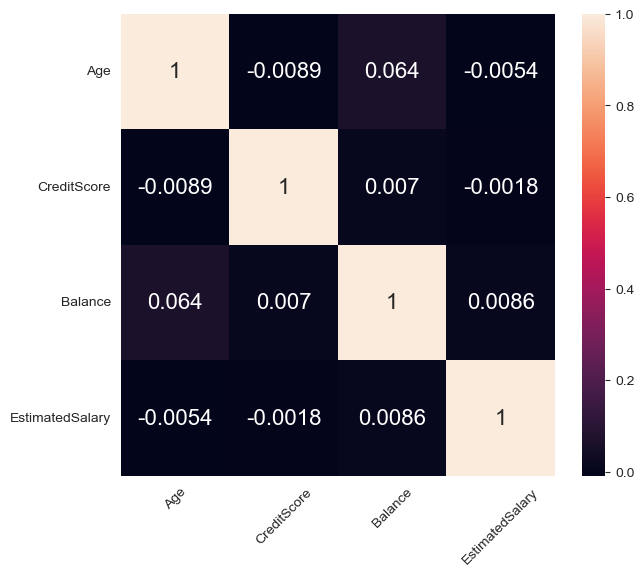

In [15]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

None of the continuous variables have a multicollinear relationship, so we can keep all these.

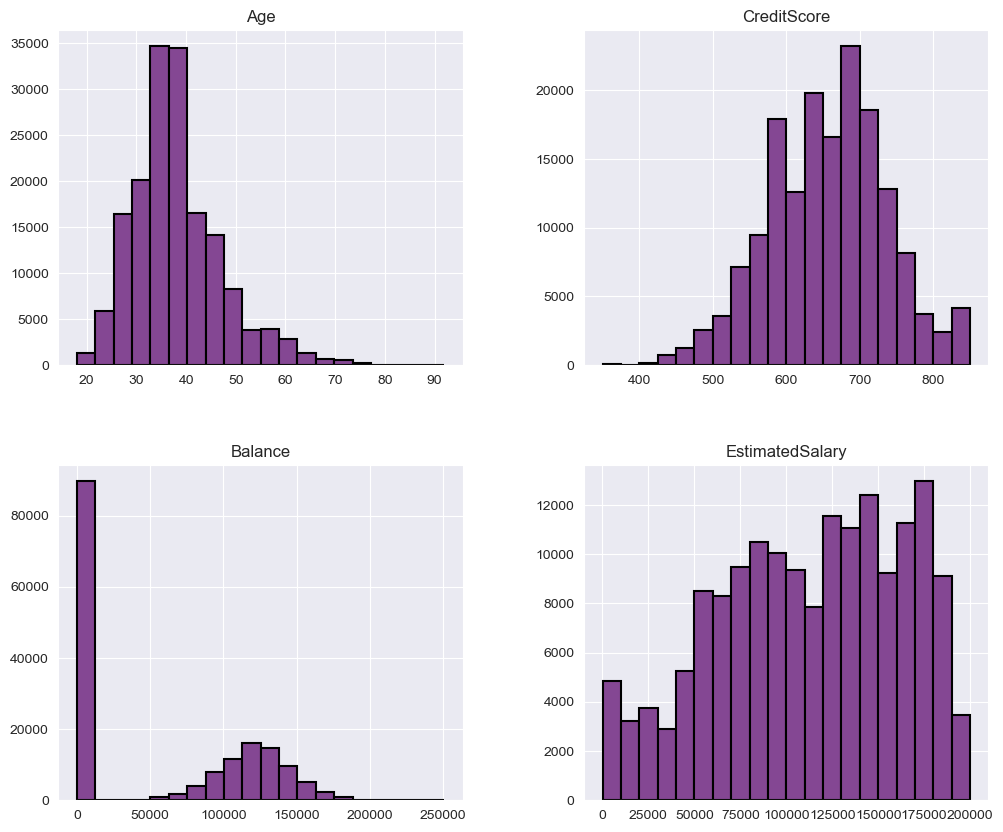

In [16]:
df[continuous].hist(figsize=(12, 10),
                    bins=20,
                    edgecolor='black',
                    layout=(2, 2),
                    linewidth=1.5);

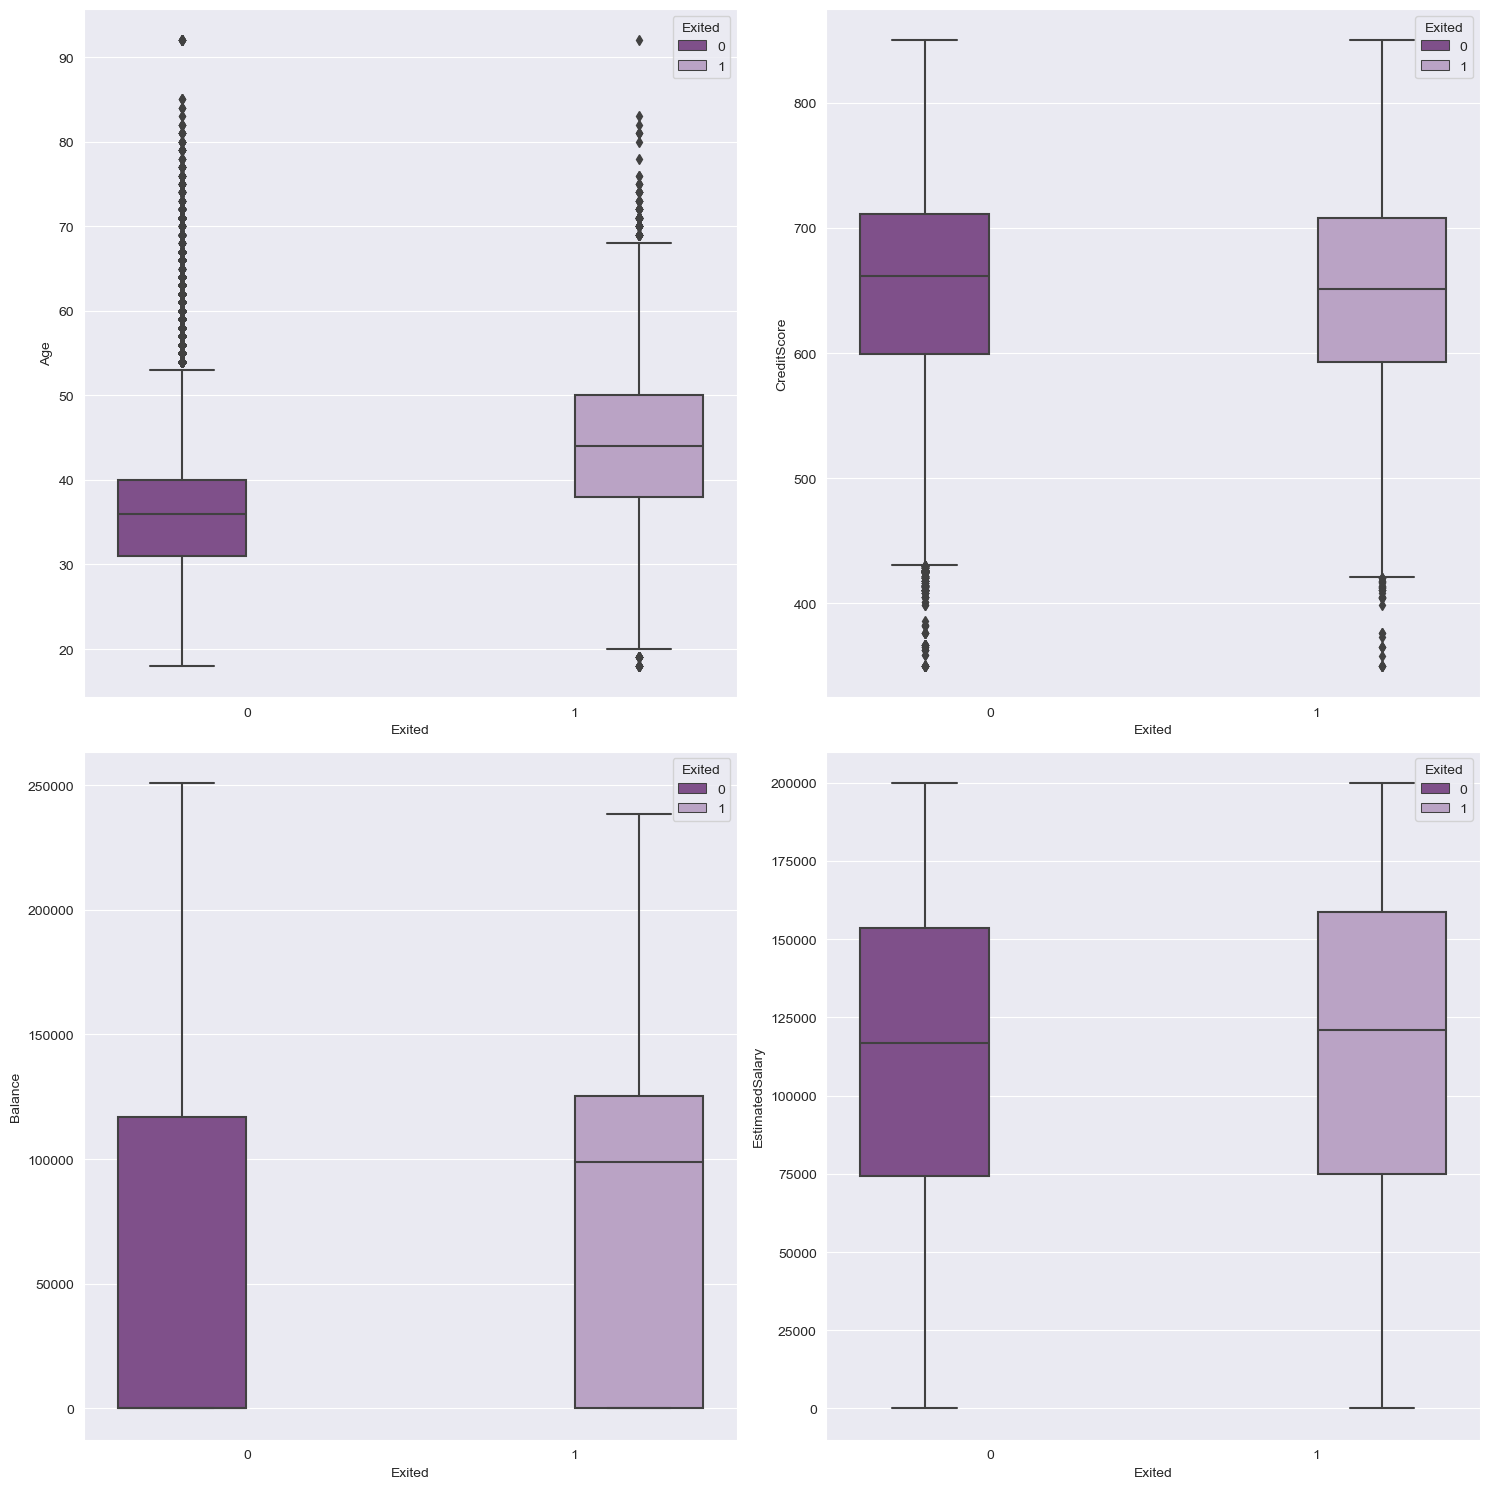

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(continuous):
    sns.boxplot(y=column, x='Exited', hue='Exited', data=df, ax=axes[i])
plt.tight_layout()
plt.show()

* Age: As inferred from the desrciptive statistics, older customers tend to churn more than younger customers. Bank may not be as appealing to older customers- things like the loss of in-person banks and a lack of benefits, or handling of pensions may influence this. 

* Credit Score: Although credit score is slightly negatively skewed, there is no signifcant difference in the credit score column between churned and retained customers. 

* Balance: Customers with a higher bank balance are slightly more likely to churn. This suggest no products or policies in place rewarding those with higher bank balances i.e. higher savings interest rate.

* Estimated Salary: Estimated Salary has quite a varied devation, and the boxplot indicates that those with a higher salary are more likely to churn. This suggest no products or policies in place rewarding those who will bring more earnings to the bank, and will likely have a higher lending potential.

### Categorical Variables: Geography, Gender, Tenure, NumOfProducts, HasCrCard & IsActiveMember

In [18]:
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

In [19]:
#Printing the value counts for the continuous columns
for column in categorical:
    print("Value counts for", column, ":")
    print(df[column].value_counts())
    print()

Value counts for Geography :
France     94215
Spain      36213
Germany    34606
Name: Geography, dtype: int64

Value counts for Gender :
Male      93150
Female    71884
Name: Gender, dtype: int64

Value counts for Tenure :
2     18045
7     17810
4     17554
8     17520
5     17268
1     16760
9     16709
3     16630
6     15822
10     5909
0      5007
Name: Tenure, dtype: int64

Value counts for NumOfProducts :
2    84291
1    77374
3     2894
4      475
Name: NumOfProducts, dtype: int64

Value counts for HasCrCard :
1.0    124428
0.0     40606
Name: HasCrCard, dtype: int64

Value counts for IsActiveMember :
0.0    82885
1.0    82149
Name: IsActiveMember, dtype: int64



#### Checking for multicollinearity between categorical variables

C:\Users\eilid\AppData\Local\Temp\ipykernel_13236\155750028.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[categorical].corr(),


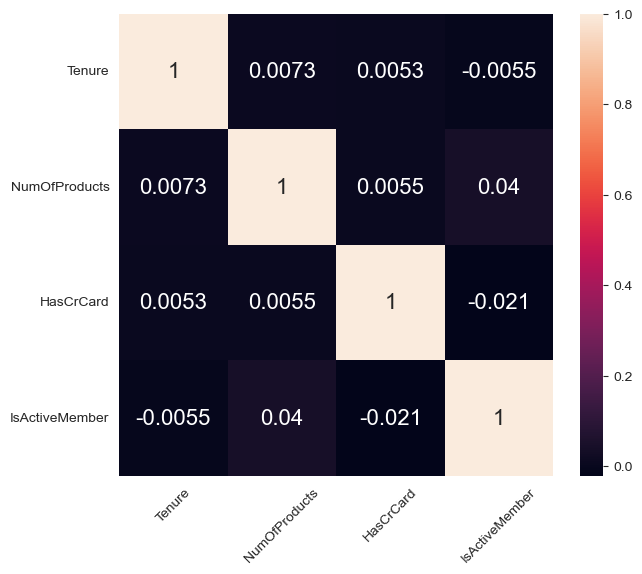

In [20]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df[categorical].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

* Tenure and IsActiveMember have a slightly negative correlation
* NumOfProducts and IsActiveMember have a slightly positive correlation
* HasCrCard and IsActiveMember have a slightly negative correlation
* Tenure and NumofProducts have a sligtly positive correlation

It's worth exploring the feature engineering of some of these variables 

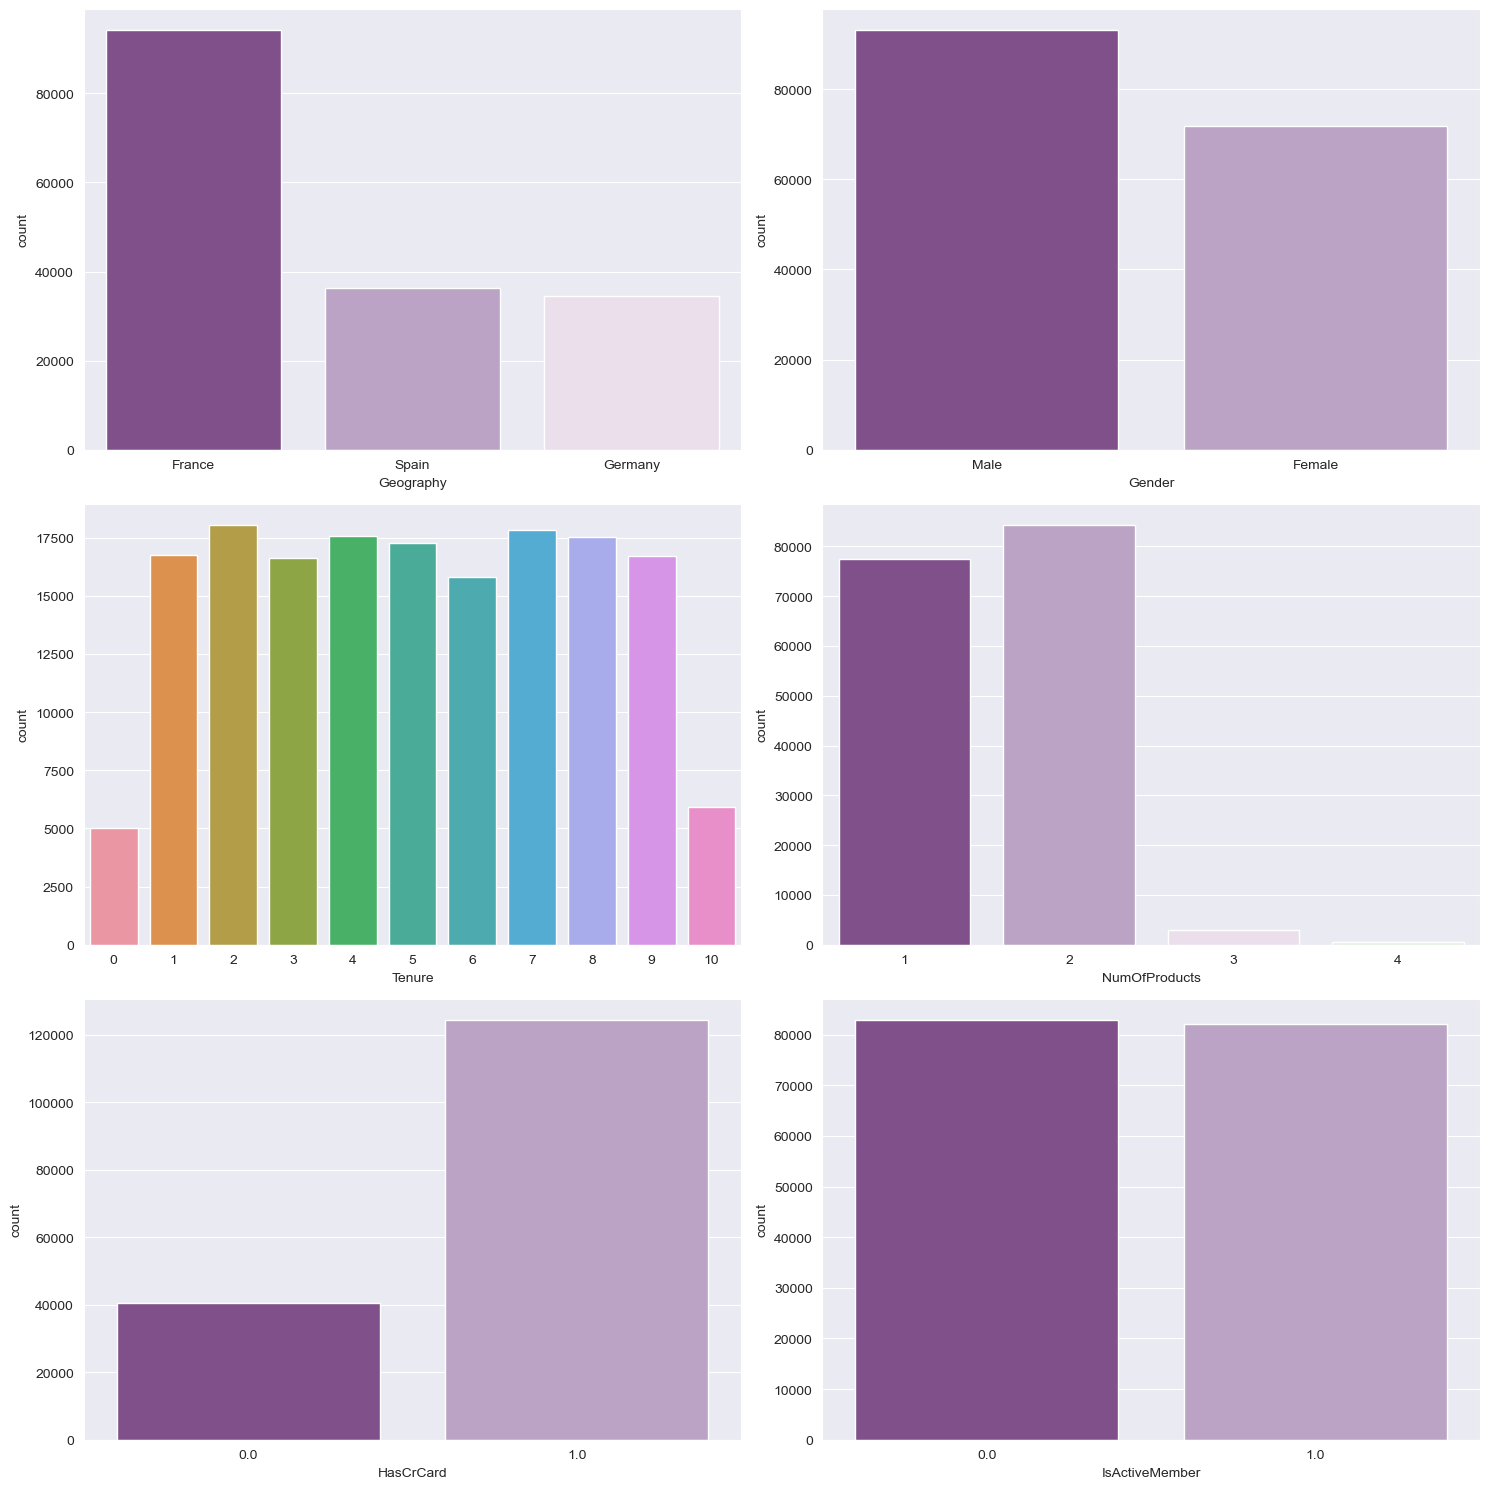

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(categorical):
    sns.countplot(x=column, data=df, ax=axes[i])

plt.tight_layout()
plt.show()

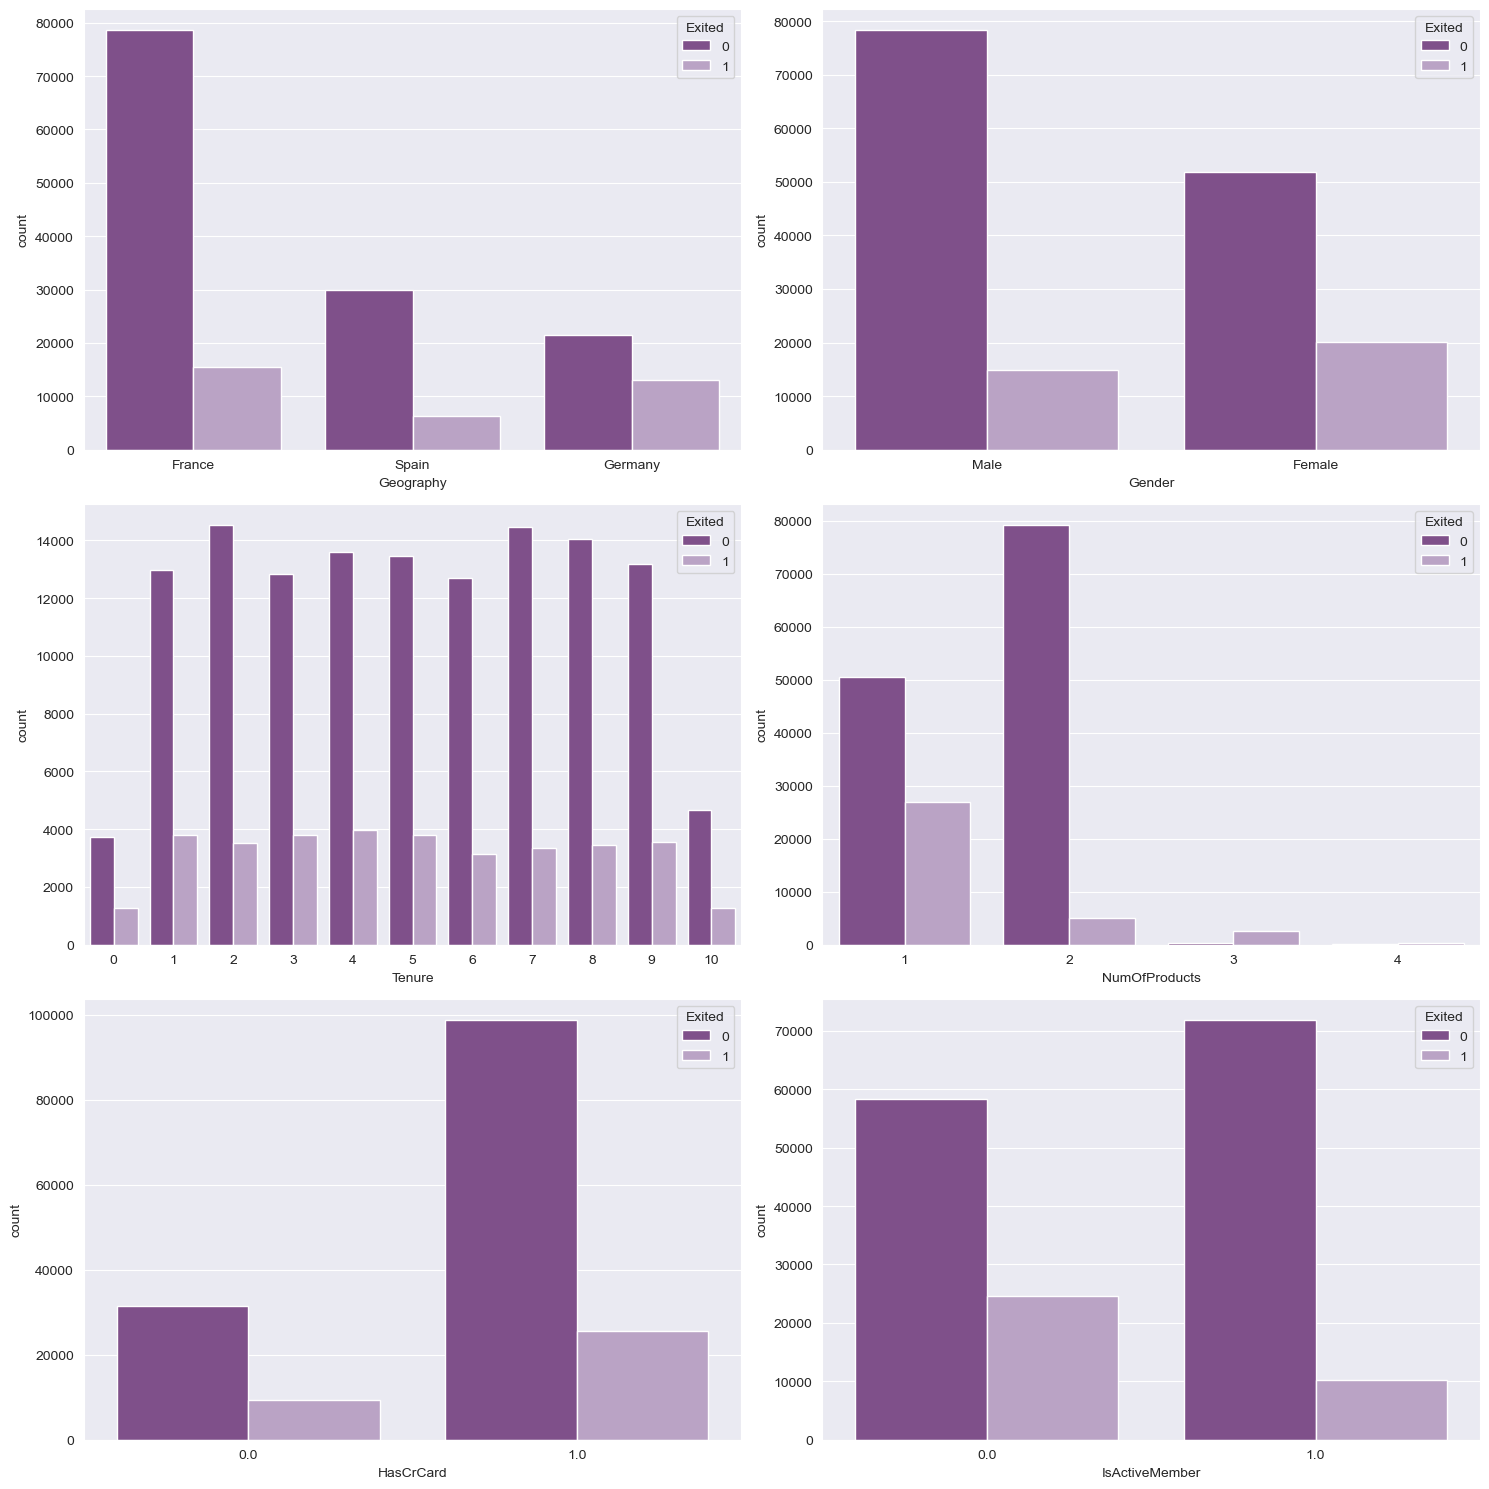

In [22]:
# Set up the layout for subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(categorical):
    sns.countplot(x=column, hue='Exited', data=df, ax=axes[i])
plt.tight_layout()
plt.show()

Geography: The majority of customers reside in France, with Spain and Germany representing equal portions of customers. Customers in France are more likely to churn, but Germany has the highest ratio of churned to retained customers. This could indicate a lack of services or higher competition in Germany.

Gender: There are more male than female customers, and female customers are more likely to churn overall. 

Tenure: Customers are least likely to churn in the 1st and 10th year, and churn rates are highest during the 2nd and 7th year. This could be due to a bank policy of higher rewards for 1st year holders i.e. cash rewards for switching bank accounts. However, tenure distribution does not show any uniform pattern for churn, and so tenure does not seem to affect the churn rate.

Number of Products (NumOfProducts): The majority of customers have 2 products, with those with 1 product being the most likely to churn. This follows a similar pattern for tenure in that customers may be taking advantage of first year benefits policies offered by the bank and then churning after the first year. Customers with 2 products are the second most likely to churn, but the rate is much lower than that of 1. Interestingly, having 3 products has the highest rate of churning. 

Has Credit Card (HasCrCard): The majority of customers have a credit card. Having a credit card does not appear to affect the churn rate.

Is Active Member (IsActiveMember): Roughly half the customers are inactive, and inactive customers are more likely to churn.


# Data Preprocessing

### Outliers

In [23]:
#Function to define the outlier thresholds
def outlier_thresholds(df, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = df[variable].quantile(low_quantile)
    quantile_three = df[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [24]:
# Function to check for outliers based on the above thresholds
def has_outliers(df, continuous, plot=False):
    for col in continuous:
        low_limit, up_limit = outlier_thresholds(df, col)
        if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None):
            number_of_outliers = df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0]
            print(col, " : ", number_of_outliers, "outliers")
            #variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
#Return outliers
for var in continuous:
    print(var, "has " , has_outliers(df, [var]),  "Outliers")

Age has  None Outliers
CreditScore has  None Outliers
Balance has  None Outliers
EstimatedSalary has  None Outliers


### Feature Selection 

The EDA has revealed more features than can be dropped as they do not affect customer churn. As a futher measure, all  the continous variables undergo both Pearson r and the Spearman ρ tests, and categorical variables undergo a chi-sqaure test.

#### Pearson r and the Spearman ρ for continous variables

In [25]:
corr_array, p_array = [], []
for column in continuous:
    pearson_corr, pearson_p_value = pearsonr(df[column], df['Exited']) #PearsonR
    spearman_corr, spearman_p_value = spearmanr(df[column], df['Exited']) #SpearmanP
    corr_array.append((pearson_corr, spearman_corr))
    p_array.append((pearson_p_value, spearman_p_value)) # Append results to arrays for a df

df_corr = pd.DataFrame({
    'Variable': continuous,
    'Pearson_corr': [corr[0] for corr in corr_array],
    'Spearman_corr': [corr[1] for corr in corr_array],
    'Pearson_p-value': [p_value[0] for p_value in p_array],
    'Spearman_p-value': [p_value[1] for p_value in p_array]
})

df_corr

,Variable,Pearson_corr,Spearman_corr,Pearson_p-value,Spearman_p-value
0,Age,0.340768,0.354665,0.000000e+00,0.000000e+00
1,CreditScore,-0.027383,-0.029120,9.373557e-29,2.663270e-32
2,Balance,0.129743,0.126417,0.000000e+00,0.000000e+00
3,EstimatedSalary,0.018827,0.019997,2.027177e-14,4.494482e-16


As predicted from the initial EDA, 'EstimatedSalary' and 'CreditScore' both scored very close to zero in both Pearson and Spearman correlation efficents indacting they have almost no linear relationship and very little impact on the target variable.

In [26]:
features_drop = ['EstimatedSalary', 'CreditScore']
df = df.drop(features_drop, axis=1)

#### Chi-sqaure test for catergorical vairables

In [27]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(df[column], df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2) #Create array for df
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,29130.479017,0.000000e+00
0,Geography,7358.673765,0.000000e+00
5,IsActiveMember,7293.408511,0.000000e+00
1,Gender,3538.452550,0.000000e+00
2,Tenure,265.458532,3.028684e-51
4,HasCrCard,80.780230,2.522693e-19


Similarly as predicted from the initial EDA, Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05, therefore, we can safely drop these features from the dataset. 

In [28]:
features_drop = ['Tenure', 'HasCrCard']
df = df.drop(features_drop, axis=1)

In [29]:
df.head()

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited
0,France,Male,33.0,0.00,2,0.0,0
1,France,Male,33.0,0.00,2,1.0,0
2,France,Male,40.0,0.00,2,0.0,0
3,France,Male,34.0,148882.54,1,1.0,0
4,Spain,Male,33.0,0.00,2,1.0,0


### Encoding Catergorical Features

In [30]:
# Label encoder selected over one-hot endocding. Note, did try both, and they had no impact on model performance.
# Label was kept as no high dimensionality. 
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Geography'] = LabelEncoder().fit_transform(df['Geography'])

In [31]:
df.head()

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited
0,0,1,33.0,0.00,2,0.0,0
1,0,1,33.0,0.00,2,1.0,0
2,0,1,40.0,0.00,2,0.0,0
3,0,1,34.0,148882.54,1,1.0,0
4,2,1,33.0,0.00,2,1.0,0


### Scaling

'Age' ranges from quite small integers (18-92) whereas 'Balance' has much larger integers (0-250,898). The difference between these integers will cause the classification models to misinterpret the data, and so will need to be standard scaled.

In [32]:
# Standard scaling was used as the 'Age' and 'Balance' variables were on vastly different scales. 
# It also does not affect the interpretability of the data.
scaler = StandardScaler()

scl_columns = [ 'Age', 'Balance']
df[scl_columns] = scaler.fit_transform(df[scl_columns])

### Creating 'X_train' & 'Y_train'

In [33]:
y = df['Exited']
X = df.drop('Exited', 1)

C:\Users\eilid\AppData\Local\Temp\ipykernel_13236\2998808209.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop('Exited', 1)


In [34]:
print(X.shape, y.shape)

(165034, 6) (165034,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)

### Using SMOTE to rebalance 'Exited' (Y_train)

In [36]:
y_train.value_counts()

0    104061
1     27966
Name: Exited, dtype: int64

In [37]:
over = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    104061
1    104061
Name: Exited, dtype: int64

In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(208122, 6) (33007, 6) (208122,) (33007,)


# Modelling

### Baseline Models 

3 classifiers were selected as the initial baseline; Random Forest, Descion Tree, and Gradient Boosting. 

The use of SVM was also explored, but due to time and computational constraits, this could not complete. 

In [39]:
##### Random Forest Classifier #####
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

random_forest_predictions = random_forest_model.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions, average='weighted')
random_forest_recall = recall_score(y_test, random_forest_predictions, average='weighted')
random_forest_f1 = f1_score(y_test, random_forest_predictions, average='weighted')

random_forest_feature_importance = random_forest_model.feature_importances_

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {random_forest_accuracy:.2f}")
print(f"Precision: {random_forest_precision:.2f}")
print(f"Recall: {random_forest_recall:.2f}")
print(f"F1-score: {random_forest_f1:.2f}")
print()

##### Decision Tree Classifier #####
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_precision = precision_score(y_test, decision_tree_predictions, average='weighted')
decision_tree_recall = recall_score(y_test, decision_tree_predictions, average='weighted')
decision_tree_f1 = f1_score(y_test, decision_tree_predictions, average='weighted')

decision_tree_feature_importance = decision_tree_model.feature_importances_

print("Decision Tree Classifier Metrics:")
print(f"Accuracy: {decision_tree_accuracy:.2f}")
print(f"Precision: {decision_tree_precision:.2f}")
print(f"Recall: {decision_tree_recall:.2f}")
print(f"F1-score: {decision_tree_f1:.2f}")
print()

##### Gradient Boosting #####
gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train, y_train)

gradient_boosting_predictions = gradient_boosting_model.predict(X_test)
gradient_boosting_accuracy = accuracy_score(y_test, gradient_boosting_predictions)
gradient_boosting_precision = precision_score(y_test, gradient_boosting_predictions, average='weighted')
gradient_boosting_recall = recall_score(y_test, gradient_boosting_predictions, average='weighted')
gradient_boosting_f1 = f1_score(y_test, gradient_boosting_predictions, average='weighted')

gradient_boosting_feature_importance = gradient_boosting_model.feature_importances_

print("Gradient Boosting Metrics:")
print(f"Accuracy: {gradient_boosting_accuracy:.2f}")
print(f"Precision: {gradient_boosting_precision:.2f}")
print(f"Recall: {gradient_boosting_recall:.2f}")
print(f"F1-score: {gradient_boosting_f1:.2f}")
print()

Random Forest Classifier Metrics:
Accuracy: 0.80
Precision: 0.83
Recall: 0.80
F1-score: 0.81

Decision Tree Classifier Metrics:
Accuracy: 0.79
Precision: 0.82
Recall: 0.79
F1-score: 0.80

Gradient Boosting Metrics:
Accuracy: 0.81
Precision: 0.85
Recall: 0.81
F1-score: 0.82



### Classification Report for Baseline Models

In [51]:
models = [
    ('Random Forest Classifier', random_forest_predictions),
    ('Decision Tree Classifier', decision_tree_predictions),
    ('Gradient Boosting', gradient_boosting_predictions),
    
]

for name, predictions in models:
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, predictions))
    print()

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     26052
           1       0.52      0.70      0.60      6955

    accuracy                           0.80     33007
   macro avg       0.72      0.76      0.73     33007
weighted avg       0.83      0.80      0.81     33007


Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     26052
           1       0.50      0.69      0.58      6955

    accuracy                           0.79     33007
   macro avg       0.71      0.75      0.72     33007
weighted avg       0.82      0.79      0.80     33007


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     26052
           1       0.53      0.80      0.64      6955

    accuracy                   

### Confusion Matrix for Baseline Models

In [54]:
models = [
    ('Random Forest Classifier', random_forest_predictions),
    ('Gradient Boosting', gradient_boosting_predictions),
    ('Decision Tree Classifier', decision_tree_predictions),
]

for name, predictions in models:
    cm = confusion_matrix(y_test, predictions)
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()

Confusion Matrix for Random Forest Classifier:
[[21550  4502]
 [ 2093  4862]]

Confusion Matrix for Gradient Boosting:
[[21075  4977]
 [ 1393  5562]]

Confusion Matrix for Decision Tree Classifier:
[[21362  4690]
 [ 2173  4782]]



Based on the intial baseline metrics, the Gradient Boosting classifier performs better than the Random Forest and Descion Tree classifiers. In addition, it has the highest precision (53%) and recall (80%), indicating fewer false positives and correctly identifying a larger proportion of acutal churned customers.

Because of this, we will now used optimised versions of gradient boosting algorithms (XGBoost, LightGBM, and CatBoost). 

## XGBoost, LightGBM, and CatBoost Classifiers

In [40]:
##### XGBoost Classifier #####
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions, average='weighted')
xgb_recall = recall_score(y_test, xgb_predictions, average='weighted')
xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')

xgb_feature_importance = xgb_model.feature_importances_

print("XGBoost Classifier Metrics:")
print(f"Accuracy: {xgb_accuracy:.2f}")
print(f"Precision: {xgb_precision:.2f}")
print(f"Recall: {xgb_recall:.2f}")
print(f"F1-score: {xgb_f1:.2f}")
print()

##### LightGBM Classifier #####
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_predictions)
lgb_precision = precision_score(y_test, lgb_predictions, average='weighted')
lgb_recall = recall_score(y_test, lgb_predictions, average='weighted')
lgb_f1 = f1_score(y_test, lgb_predictions, average='weighted')

lgb_feature_importance = lgb_model.feature_importances_

print("LightGBM Classifier Metrics:")
print(f"Accuracy: {lgb_accuracy:.2f}")
print(f"Precision: {lgb_precision:.2f}")
print(f"Recall: {lgb_recall:.2f}")
print(f"F1-score: {lgb_f1:.2f}")
print()

##### CatBoost Classifier #####
cb_model = cb.CatBoostClassifier(verbose=False)
cb_model.fit(X_train, y_train)

cb_predictions = cb_model.predict(X_test)
cb_accuracy = accuracy_score(y_test, cb_predictions)
cb_precision = precision_score(y_test, cb_predictions, average='weighted')
cb_recall = recall_score(y_test, cb_predictions, average='weighted')
cb_f1 = f1_score(y_test, cb_predictions, average='weighted')

cb_feature_importance = cb_model.feature_importances_

print("CatBoost Classifier Metrics:")
print(f"Accuracy: {cb_accuracy:.2f}")
print(f"Precision: {cb_precision:.2f}")
print(f"Recall: {cb_recall:.2f}")
print(f"F1-score: {cb_f1:.2f}")
print()


XGBoost Classifier Metrics:
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1-score: 0.83

LightGBM Classifier Metrics:
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1-score: 0.83

CatBoost Classifier Metrics:
Accuracy: 0.82
Precision: 0.85
Recall: 0.82
F1-score: 0.83



Overall, XGBoost, LightGBM, and CatBoost are only slightly better performing than the baseline models. There is a slight improvement in predicting customer churn.

### Confusion Matrix for XGBoost, LightGBM, and CatBoost

In [52]:
models = [
    ('XGBoost Classifier', xgb_predictions),
    ('LightGBM Classifier', lgb_predictions),
    ('CatBoost Classifier', cb_predictions)
]

for name, predictions in models:
    cm = confusion_matrix(y_test, predictions)
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()

Confusion Matrix for XGBoost Classifier:
[[21817  4235]
 [ 1664  5291]]

Confusion Matrix for LightGBM Classifier:
[[21645  4407]
 [ 1558  5397]]

Confusion Matrix for CatBoost Classifier:
[[21967  4085]
 [ 1704  5251]]



### Classification Report for XGBoost, LightGBM, and CatBoost

In [53]:
models = [
    ('XGBoost Classifier', xgb_predictions),
    ('LightGBM Classifier', lgb_predictions),
    ('CatBoost Classifier', cb_predictions)
]

for name, predictions in models:
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, predictions))
    print()

Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     26052
           1       0.56      0.76      0.64      6955

    accuracy                           0.82     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.82      0.83     33007


Classification Report for LightGBM Classifier:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     26052
           1       0.55      0.78      0.64      6955

    accuracy                           0.82     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.82      0.83     33007


Classification Report for CatBoost Classifier:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     26052
           1       0.56      0.75      0.64      6955

    accuracy                           0

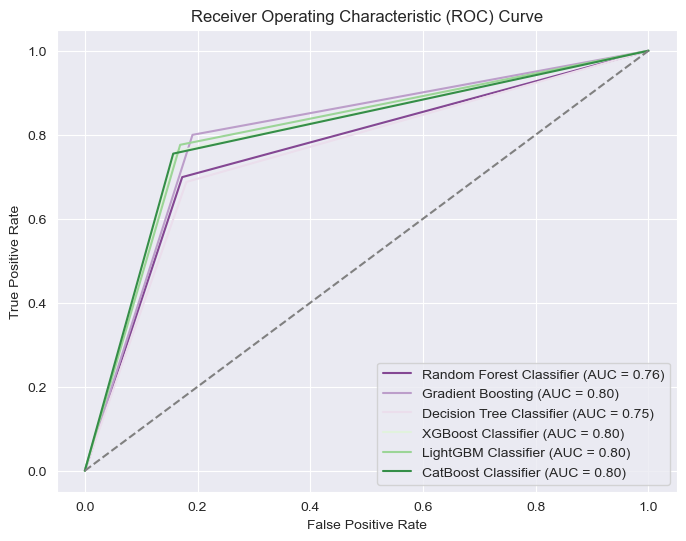

In [43]:
# Calculate ROC curve and AUC score for each model
models = [
    ('Random Forest Classifier', random_forest_predictions),
    ('Gradient Boosting', gradient_boosting_predictions),
    ('Decision Tree Classifier', decision_tree_predictions),
    ('XGBoost Classifier', xgb_predictions),
    ('LightGBM Classifier', lgb_predictions),
    ('CatBoost Classifier', cb_predictions)
]

plt.figure(figsize=(8, 6))

for name, predictions in models:
    fpr, tpr, _ = roc_curve(y_test, predictions)
    auc_score = roc_auc_score(y_test, predictions)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Feature Importance 

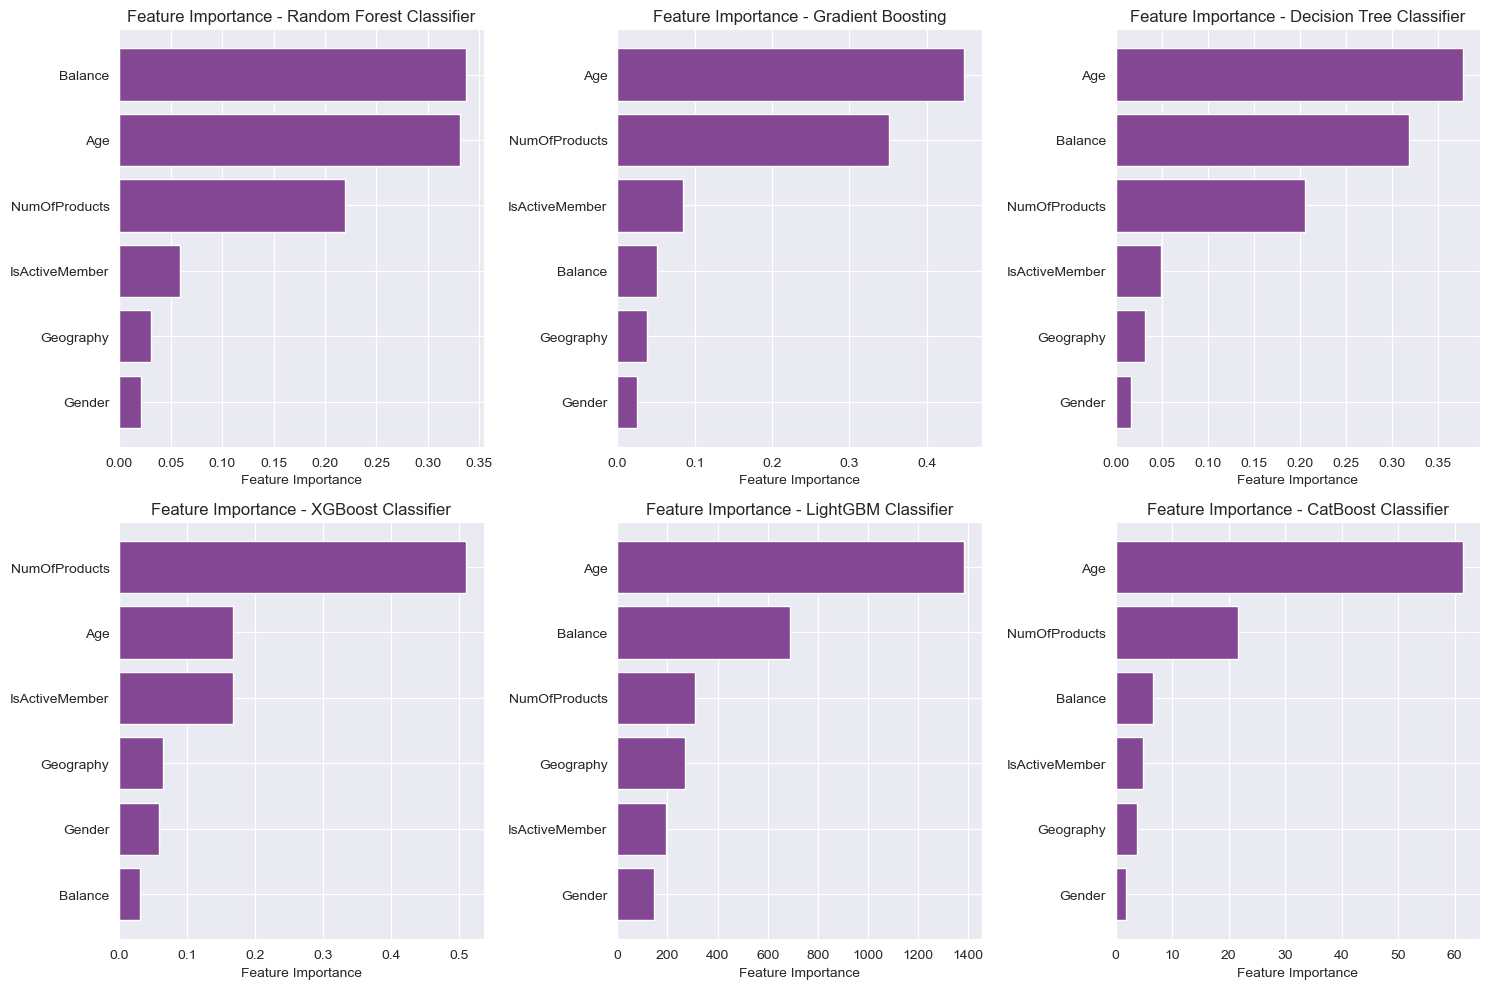

In [44]:
feature_names = X_train.columns.tolist()

# Define a function to plot feature importance
def plot_feature_importance(feature_importance, feature_names, model_name, ax):
    sorted_idx = np.argsort(feature_importance)
    ax.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Feature Importance - {model_name}')

# Assuming you have trained models and extracted feature importance already
# and feature_names extracted from X_train

# Example feature importance for each model
feature_importance_data = [
    ('Random Forest Classifier', random_forest_feature_importance),
    ('Gradient Boosting', gradient_boosting_feature_importance),
    ('Decision Tree Classifier', decision_tree_feature_importance),
    ('XGBoost Classifier', xgb_feature_importance),
    ('LightGBM Classifier', lgb_feature_importance),
    ('CatBoost Classifier', cb_feature_importance)
]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for (model_name, feature_importance), ax in zip(feature_importance_data, axs.flatten()):
    plot_feature_importance(feature_importance, feature_names, model_name, ax)

plt.tight_layout()
plt.show()


### Model Tuning using GridSearchCV

Note: This was not used in the final tuning model, but will be used in future versions.

In [46]:
# Define parameter grids for each model
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4],
}

lgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4],
}

cb_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.05],
    'depth': [3, 4],
}

models = [
    ('XGBoost Classifier', xgb.XGBClassifier(), xgb_param_grid),
    ('LightGBM Classifier', lgb.LGBMClassifier(), lgb_param_grid),
    ('CatBoost Classifier', cb.CatBoostClassifier(verbose=False), cb_param_grid)
]

for name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train[:len(X_train)//10], y_train[:len(y_train)//10])  # Using 1/10th of the data
    
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    refined_param_grid = {key: [best_params[key]] for key in best_params}
    refined_grid_search = GridSearchCV(best_estimator, refined_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    refined_grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {refined_grid_search.best_params_}")
    print(f"Best score for {name}: {refined_grid_search.best_score_:.2f}")
    print()

    val_score = refined_grid_search.best_estimator_.score(X_val, y_val)
    print(f"Validation score for {name}: {val_score:.2f}")
    print()


Best parameters for XGBoost Classifier: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best score for XGBoost Classifier: 0.83

Validation score for XGBoost Classifier: 0.82

[LightGBM] [Info] Number of positive: 8333, number of negative: 8316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 16649, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500511 -> initscore=0.002042
[LightGBM] [Info] Start training from score 0.002042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Info] Number of positive: 83282, number of negative: 83215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 166497, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500201 -> initscore=0.000805
[LightGBM] [Info] Start training from score 0.000805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

### Conclusions

* All three classifiers have similar performance in predicting churned customers, with precision, recall, F1-score, and accuracy hovering around 55-56%, 75-78%, 64%, and 82% respectively.
* There is no significant difference in performance between XGBoost, LightGBM, and CatBoost based on these metrics.

### Future work

* Feature Engineering - exploring the relationship of age and tenure, combining credit score, salary, and balance, or just salary and balance
* Hyperparameter Tuning - The GridSearchCv is very rudimentary. Would like to expand the search for parameters and use better fine-tinued hyper parameters.
* Also realised that there was a mistake made with the Pearson and Spearman correlation tests, as these measure the relationship to other variables, not the targeted variable. Future versions will fix this and revise the model engineering if needed. 